In [27]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
from scipy.spatial import distance
import time
import platform

from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, load_network, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import create_datasets

transformVar = {"Test": transforms.Compose([
    transforms.Resize(128),    #Already 184 x 184
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     normalize
]),
    "Train": transforms.Compose([
    transforms.Resize(128),  # Already 184 x 184
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#     normalize
    ])
}

In [32]:
logging.basicConfig(format='%(message)s',level=logging.INFO)
channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nr_net = 0 

version = nr_net + 10
num_input_frames = 5
num_output_frames = 10
network_type = "7_kernel_3LSTM"

if 'Darwin' in platform.system():
    data_dir = './'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("./Results"):
    os.mkdir("./Results")
results_dir = "./Results/" + network_type + "_v%03d/" % version

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)
    
# Data
filename_data = results_dir + "all_data.pickle"
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = create_datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)

train_dataset.root_dir = './Video_Data/'
val_dataset.root_dir = './Video_Data/'
test_dataset.root_dir = './Video_Data/'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

model = Network(device, channels)
model = load_network(model, device, "Results/7_kernel_3LSTM_v010/model.pt")

Loading datasets


In [34]:
from utils.training import test

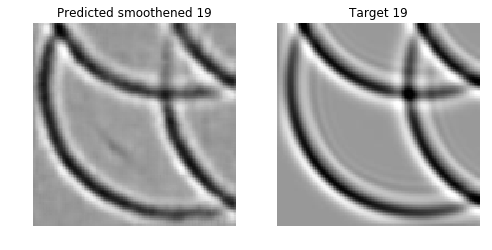

In [7]:
plot_predictions(output_frame, target_frame, channels)

In [8]:
output_frame[0,0:1,:,:].size()

torch.Size([1, 128, 128])

In [9]:
output_frame.size()

torch.Size([16, 20, 128, 128])

In [10]:
target_frame.size()

torch.Size([16, 20, 128, 128])

In [11]:
predicted = output_frame[i, -channels:, :, :].cpu().detach()

In [12]:
predicted.size()

torch.Size([1, 128, 128])

In [13]:
batch['image'].size()

torch.Size([16, 100, 128, 128])

In [14]:
num_input_frames

5

In [15]:
# def initial_input(model, image_series, starting_point, num_input_frames, channels, device, training):
n = 0
input_frames = image_series[:, (starting_point + n) * channels:(starting_point + n + num_input_frames) * channels, :, :].to(device)
output_frame = model(input_frames, training=training)
index = starting_point + n + num_input_frames
target_frame = image_series[:, index * channels:(index + 1) * channels, :, :].to(device)

In [16]:
input_frames.size()

torch.Size([16, 5, 128, 128])

In [17]:
image_series.size()

torch.Size([16, 100, 128, 128])

In [18]:
output_frame.size()

torch.Size([16, 1, 128, 128])

In [19]:
target_frame.size()

torch.Size([16, 1, 128, 128])

In [20]:
output_frame[:, -num_input_frames * channels:, :, :].clone().size()

torch.Size([16, 1, 128, 128])

In [21]:
# def reinsert(model, image_series, starting_point, num_input_frames, num_output_frames, output_frame, target_frame, channels, device, training):
output_frame = torch.cat((output_frame, model(output_frame[:, -num_input_frames * channels:, :, :].clone(), mode="reinserting", training=training)), dim=1)
index = starting_point + num_output_frames + num_input_frames
target_frame = torch.cat((target_frame, image_series[:, index * channels:(index + 1) * channels, :, :].to(device)), dim=1)

In [22]:
num_input_frames

5

In [23]:
output_frame.size()

torch.Size([16, 2, 128, 128])

In [24]:
starting_point

68

In [25]:
num_output_frames

10

In [26]:
num_input_frames

5

In [27]:
index

83

In [28]:
target_frame.size()

torch.Size([16, 2, 128, 128])

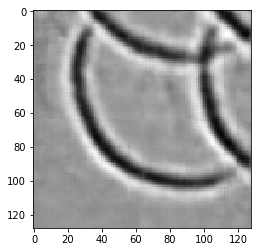

In [29]:
plt.imshow(output_frame[1,0,:,:],cmap='gray')

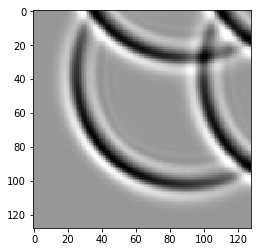

In [30]:
plt.imshow(target_frame[1,0,:,:],cmap='gray')

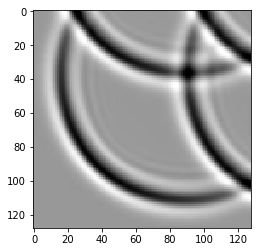

In [31]:
plt.imshow(target_frame[1,1,:,:],cmap='gray')

In [32]:
output_frame[:, -num_input_frames * channels:, :, :].clone().size()

torch.Size([16, 2, 128, 128])

In [35]:
filename_analyser = results_dir + "analyser.pickle" 
analyser = load(filename_analyser)

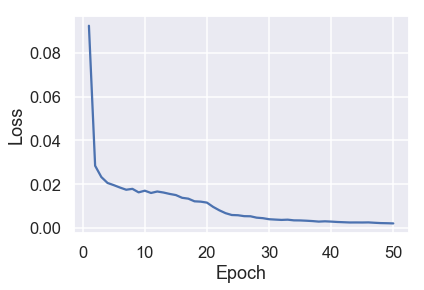

In [37]:
analyser.plot_loss()

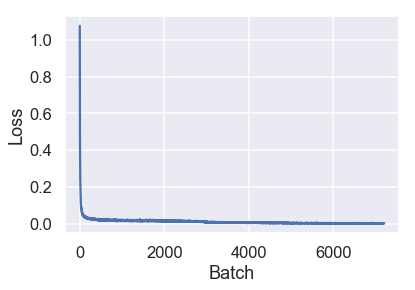

In [38]:
analyser.plot_loss_batchwise()

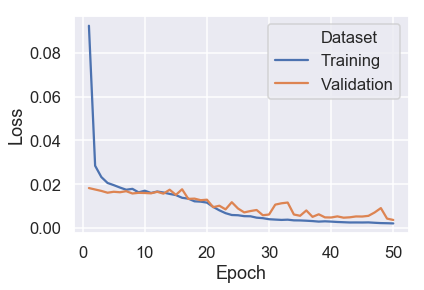

In [46]:
data = analyser.plot_validation_loss()

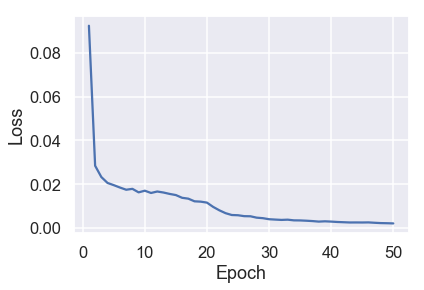

In [50]:
analyser.plot_loss()

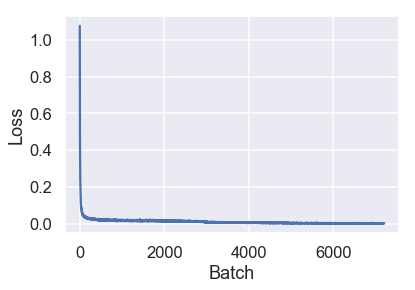

In [51]:
analyser.plot_loss_batchwise()

In [52]:
len(train_dataloader)

144

In [53]:
len(test_dataloader)

31

In [54]:
len(val_dataloader)

31